druhý obraz má červené body
barevný prostor tak abych mohl dělat segmentaci
chci ho bez morfologických operací

[0 1 3 6 8]
Center of mass for region 0: (144.00, 119.59)
Center of mass for region 1: (63.67, 30.49)
Center of mass for region 3: (229.62, 33.11)
Center of mass for region 6: (64.14, 205.41)
Center of mass for region 8: (233.43, 211.69)
[ 0  1  4  8 10]
Center of mass for region 0: (121.09, 113.04)
Center of mass for region 1: (38.42, 34.73)
Center of mass for region 4: (197.80, 34.35)
Center of mass for region 8: (197.87, 192.50)
Center of mass for region 10: (38.35, 195.87)


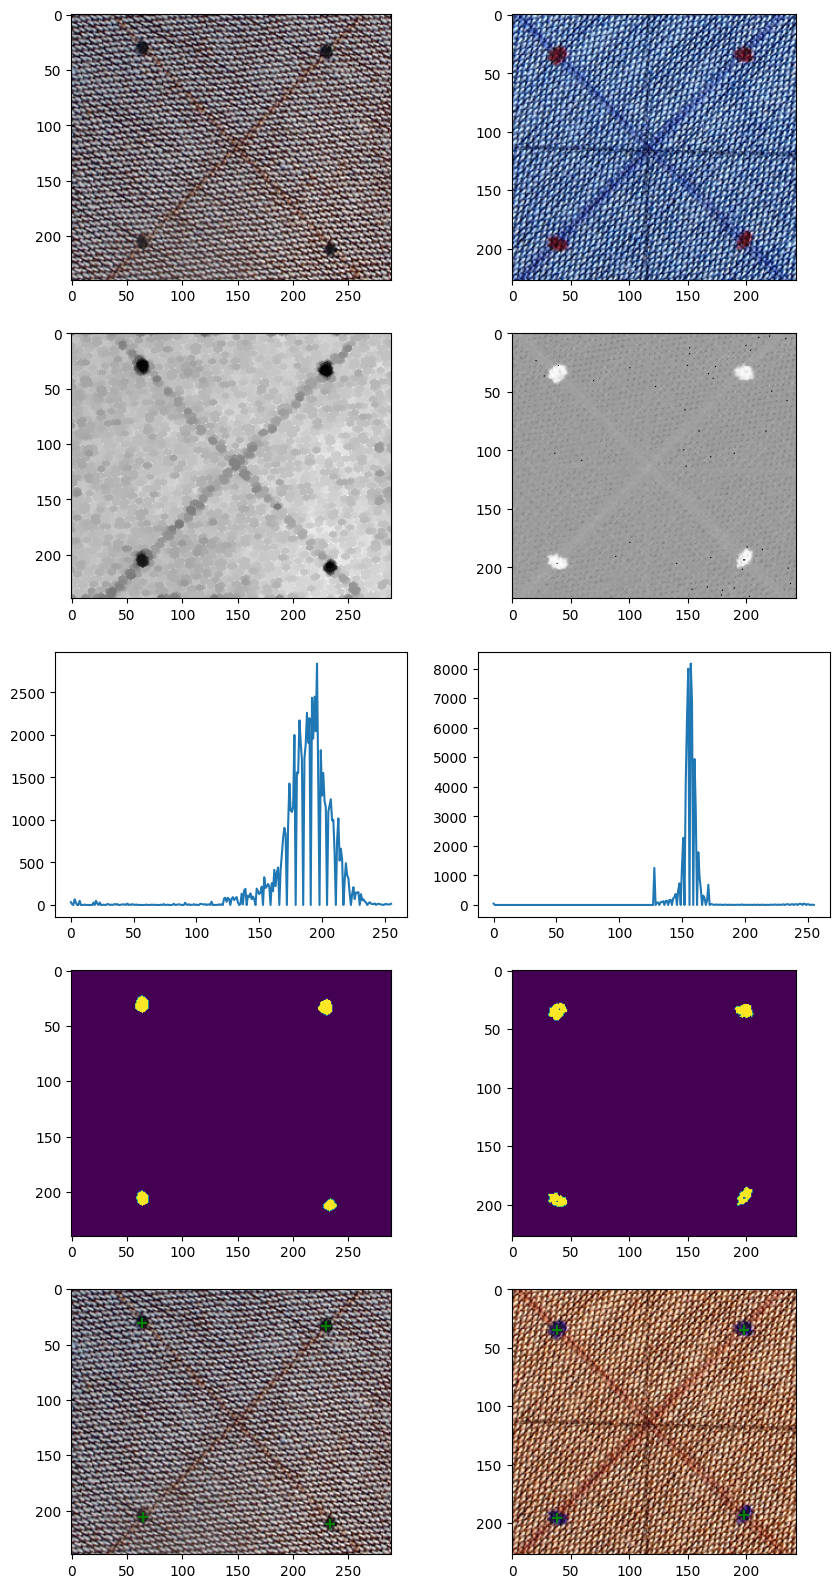

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

cv08_im1 = cv2.imread("cv08_im1.bmp")
cv08_im2 = cv2.imread("cv08_im2.bmp")


def image_color_segmentation(img, threshold):
    """
    param img: input image

    """
    # extract the color channels
    img = img.astype(np.uint8)
    background = img

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if background[i, j] >= threshold:
                img[i, j] = 0
            else:
                img[i, j] = 255

    return img


def dilatation(img):
    """
    param img: input image
    """
    # kernel ring shape 6x6
    kernel = np.array(
        [
            [0, 0, 0, 1, 0, 0],
            [0, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1, 1],
        ]
    )
    img_dilation = cv2.dilate(img, kernel, iterations=1)
    return img_dilation


def erosion(img):
    """
    param img: input image
    """
    # kernel ring shape 6x6
    kernel = np.array(
        [
            [0, 0, 0, 1, 0, 0],
            [0, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1, 1],
        ]
    )
    img_erosion = cv2.erode(img, kernel, iterations=1)
    return img_erosion


def opening(img):
    """
    param img: input image
    """
    # kernel ring shape 6x6
    kernel = np.array(
        [
            [0, 0, 0, 1, 0, 0],
            [0, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1, 1],
        ]
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img_opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img_opening


def closing(img):
    """ """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    img_closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return img_closing


def img_to_gray(img):
    """
    param img: input image
    return: gray image
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


class ColorSpace:
    def __init__(self):
        self.pixel_value = 0
        self.color_value = 0


def region_coloring(img):
    """
    region identification and coloring

    """
    # tmp_img = np.zeros_like(gray_img, dtype=ColorSpace)
    tmp_img = [[ColorSpace() for i in range(img.shape[1])] for j in range(img.shape[0])]
    tmp_img = np.array(tmp_img)

    for i in range(tmp_img.shape[0]):
        for j in range(tmp_img.shape[1]):
            if img[i, j] != 0:
                tmp_img[i, j].pixel_value = 1
                tmp_img[i, j].color_value = 0

    uniqe_color_iterator = 1
    iter = 0
    while True:
        flag_changed_color = False
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i > 0 and j > 0 and i < img.shape[0] - 1 and j < img.shape[1] - 1:
                    if tmp_img[i, j].pixel_value == 1:
                        mask = np.array(
                            [
                                tmp_img[i - 1, j - 1],
                                tmp_img[i - 1, j],
                                tmp_img[i - 1, j + 1],
                                tmp_img[i, j - 1],
                                tmp_img[i, j + 1],
                                tmp_img[i + 1, j - 1],
                                tmp_img[i + 1, j],
                                tmp_img[i + 1, j + 1],
                            ]
                        )

                        # get non black pixels from mask
                        color = [
                            x.color_value
                            for x in mask
                            if x.pixel_value == 1 and x.color_value != 0
                        ]

                        # if there is no non black pixel in mask
                        if len(color) == 0 and tmp_img[i, j].pixel_value == 1:
                            tmp_img[i, j].color_value = uniqe_color_iterator
                            uniqe_color_iterator += 1
                            flag_changed_color = True
                        elif (
                            tmp_img[i, j].pixel_value == 1
                            and min(color) != tmp_img[i, j].color_value
                        ):
                            tmp_img[i, j].color_value = min(color)
                            flag_changed_color = True
        iter += 1
        if flag_changed_color == False or iter > 20:
            break

    final_img = np.zeros_like(img, dtype=np.uint8)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if tmp_img[i, j].pixel_value == 1:
                color = tmp_img[i, j].color_value
                final_img[i, j] = color
    print(np.unique(final_img))
    return final_img


def center_of_mass(img):
    centers = []
    for i in np.unique(img):
        mask = img == i
        y, x = np.where(mask)
        print(
            "Center of mass for region {}: ({:.2f}, {:.2f})".format(
                i, np.mean(x), np.mean(y)
            )
        )
        if i != 0:
            centers.append((np.mean(x), np.mean(y)))
    return centers


plt.figure(figsize=(10, 20))
plt.subplot(5, 2, 1)
plt.imshow(cv08_im1)
plt.subplot(5, 2, 2)
plt.imshow(cv2.cvtColor(cv08_im2, cv2.COLOR_BGR2RGB))
plt.subplot(5, 2, 3)
cv08_im1_gray = img_to_gray(cv08_im1)
cv08_im1_closed = closing(cv08_im1_gray)
plt.imshow(cv08_im1_closed, cmap="gray")
plt.subplot(5, 2, 4)
cv08_im2_hsv = cv2.cvtColor(cv08_im2, cv2.COLOR_BGR2HSV)[:, :, 0]
plt.imshow(cv08_im2_hsv, cmap="gray")
plt.subplot(5, 2, 5)
plt.plot(np.histogram(cv08_im1_closed, bins=256)[0])
plt.subplot(5, 2, 6)
plt.plot(np.histogram(cv08_im2_hsv, bins=256)[0])

plt.subplot(5, 2, 7)
seg_cv08_im1 = image_color_segmentation(cv08_im1_closed, 110)
plt.imshow(seg_cv08_im1)


plt.subplot(5, 2, 8)
seg_cv08_im2 = image_color_segmentation(cv08_im2_hsv, 150)
seg_cv08_im2 = cv2.bitwise_not(seg_cv08_im2)
plt.imshow(seg_cv08_im2)


plt.subplot(5, 2, 9)
plt.imshow(cv08_im1)
im1 = region_coloring(seg_cv08_im1)
centers = center_of_mass(im1)
plt.scatter([x for x, y in centers], [y for x, y in centers], c="g", s=50, marker="+")


plt.subplot(5, 2, 10)
plt.imshow(cv08_im2)
im2 = region_coloring(seg_cv08_im2)
centers = center_of_mass(im2)
plt.scatter([x for x, y in centers], [y for x, y in centers], c="g", s=50, marker="+")
